# Autocorrelation of Eye Tracking Data
This notebook calculates the autocorrelation of raw eye tracking data. 

Objectives:
* Autocorrelation plot showing time points with especially high correlation within the time series of data

## Configuration

In [ ]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

### Check for missing packages

In [ ]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* ImageIO (`imageio` and `imageio-ffmpeg`): for reading images and accessing the webcam
* Scikit-image (`scikit-image`) for some image manipulation
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* Dlib (`dlib`) providing the HOG face detector
* OpenCV (`opencv`) for real time applications
* Imutils (`imutils`) for image manipulation with OpenCV

Running the following cell will create a file `graphs.yml` that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.


In [ ]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

### Environment Creation

To create the environment, open the. terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
```sh
conda env create -f graphs.yml
```
After running this command you have to activate the environment (Linux/MacOS: `conda activate graphs`, Windows: `activate graphs`) and then reopen the notebook in that environment.

# Main part
### Imports and directory definition
The data directory is adjusted to the folder arrangedment of the github repo. Adjust if necessary.

In [2]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nX
import glob
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import argrelextrema
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



OG_DATA_PATH = './'
DATA_PATH = './EyeBoxPos/'
PROCESSED_DATA_PATH = './Results/Autocorrelation/'

## Autocorrelation Part

### Loading
* Loading in the viewing coordinates (EyePosBox) consisting of X,Y, and Z coordinates.

### Calculation
* Using the statsmodels acf autocorrelation function to calculate the autocorrelation for every time shift of the coordinate series (for each coordinate separately).
* I save these into a table.

### Plotting
* Plotting the autocorrelation plot of (1) each coordinate separately and (2) the mean of coordinate correlations on top of each other.

### Saving
* Saving the plot and autocorrelation table. 

In [ ]:
df = pd.concat(map(pd.read_csv,glob.glob(DATA_PATH + '/*.txt')))

/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


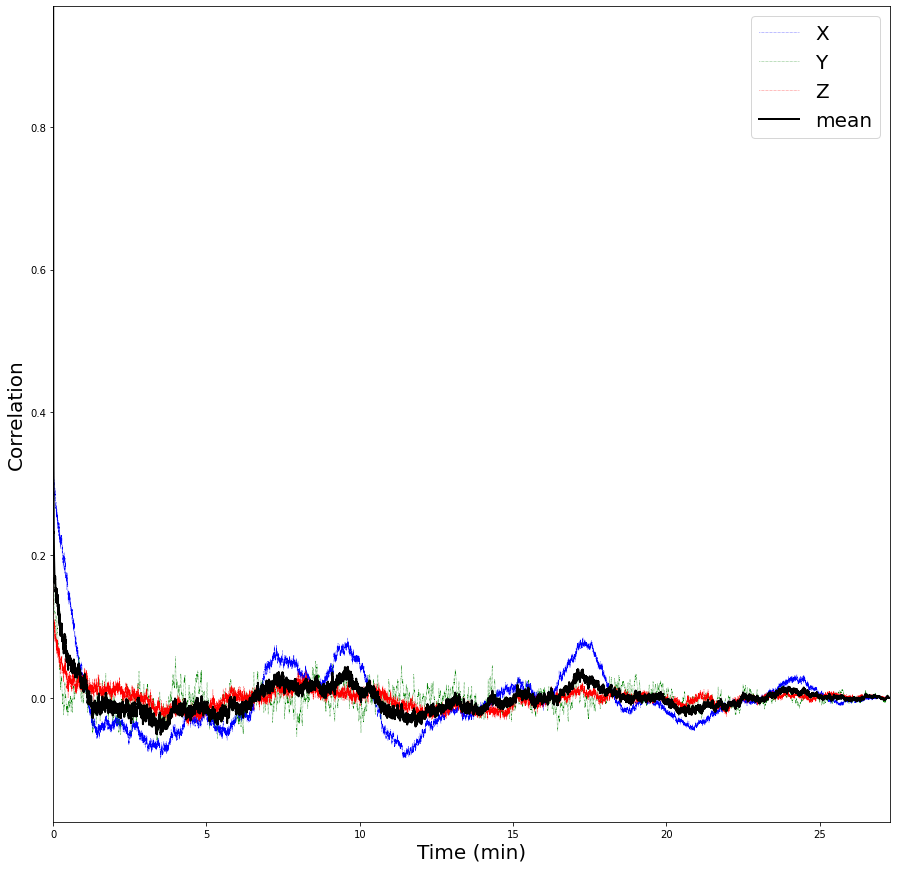

In [4]:
# Loading the first data to test the script
data = pd.read_csv(DATA_PATH + 'EyeBoxPos_VP1996.txt', names=['X','Y','Z']) 

# Removing the unwanted brackets from the data
data['X'] =  data['X'].apply(lambda x: x.replace('(','').replace(')','')) 
data['X'] = data['X'].astype('float')
data['Z'] =  data['Z'].apply(lambda x: x.replace('(','').replace(')','')) 
data['Z'] = data['Z'].astype('float')

data['time'] = data.index*0.03/60.0

data[:]


labels = ['X','Y','Z','mean']

#plot autocorrelation function
autoc_X = acf(data['X'],nlags=len(data['X'])-1)
autoc_Y = acf(data['Y'],nlags=len(data['Y'])-1)
autoc_Z = acf(data['Z'],nlags=len(data['Z'])-1)

start = 1
upperX = np.max(data['time'])
lowerX = np.min(data['time'])
upperY = np.max([autoc_X[start::],autoc_Y[start::],autoc_Z[start::]])\
                + 0.1*np.max([autoc_X[start::],autoc_Y[start::],autoc_Z[start::]])
lowerY = np.min([autoc_X[start::],autoc_Y[start::],autoc_Z[start::]])\
                - 0.1*np.max([autoc_X[start::],autoc_Y[start::],autoc_Z[start::]])


# Plotting 
if(autoc_X.size == autoc_Y.size == autoc_Z.size):
    plt.figure(figsize=(15,15))
    plt.plot(data['time'],autoc_X,ls=':',c='b',linewidth=0.5)
    plt.plot(data['time'],autoc_Y,ls=':',c='g',linewidth=0.5)
    plt.plot(data['time'],autoc_Z,ls=':',c='r',linewidth=0.5)
    plt.plot(data['time'],(autoc_X+autoc_Y+autoc_Z)/3,'k',Linewidth=2)
    plt.xlim([lowerX,upperX])
    plt.ylim([lowerY,upperY])
    plt.xlabel('Time (min)',fontsize=20)
    plt.ylabel('Correlation',fontsize=20)
    plt.legend(labels,fontsize=20,markerscale=10, loc='upper right')
else:
    disp('The sizes of autocorrelation array do not match')
    


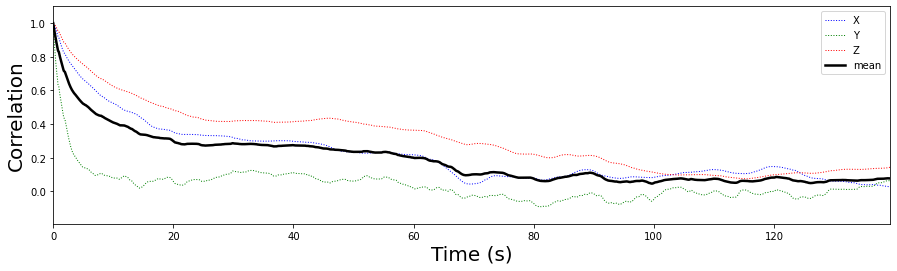

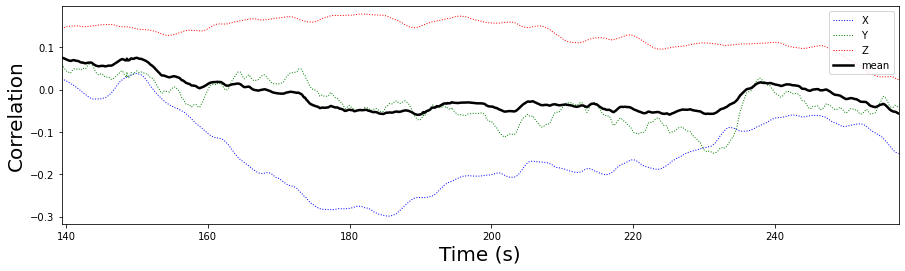

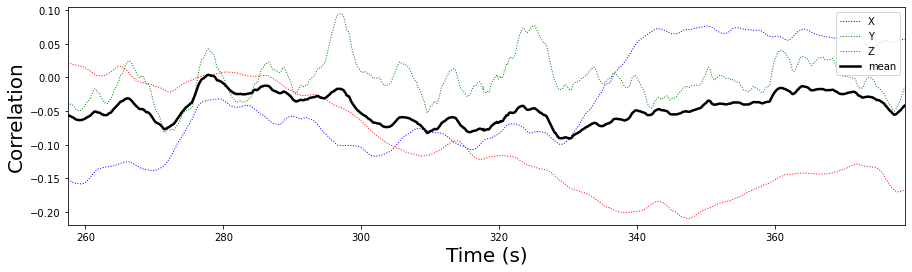

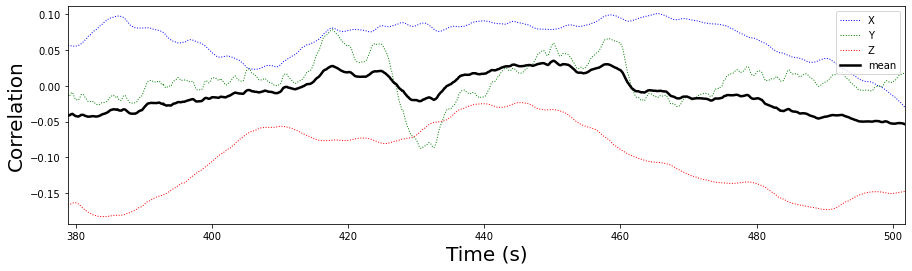

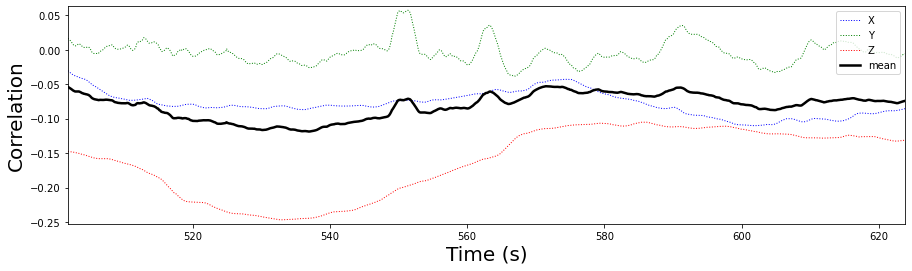

In [5]:
# Loading the first data to test the script
data = pd.read_csv(DATA_PATH + 'EyeBoxPos_VP1000.txt', names=['X','Y','Z']) 

# Removing the unwanted brackets from the data
data['X'] =  data['X'].apply(lambda x: x.replace('(','').replace(')','')) 
data['X'] = data['X'].astype('float')
data['Z'] =  data['Z'].apply(lambda x: x.replace('(','').replace(')','')) 
data['Z'] = data['Z'].astype('float')

data = data[data.values.sum(axis=1) != 0] 

data['time'] = data.index*0.03


labels = ['X','Y','Z','mean']

for idx in range(3600,6*3600,3600):
    
    timestamp = idx - 3600
    
    timestamp_next = idx

    #plot autocorrelation function
    autoc_X = acf(data['X'],nlags=len(data['X'])-1)
    autoc_Y = acf(data['Y'],nlags=len(data['Y'])-1)
    autoc_Z = acf(data['Z'],nlags=len(data['Z'])-1)
    
    # current viewed data window of the autocorrelation:
    autoc_X_t = autoc_X[timestamp:timestamp_next]
    autoc_Y_t = autoc_Y[timestamp:timestamp_next]
    autoc_Z_t = autoc_Z[timestamp:timestamp_next]


    upperX = np.max(data['time'][timestamp:timestamp_next])
    lowerX = np.min(data['time'][timestamp:timestamp_next])
    upperY = np.max([autoc_X_t, autoc_Y_t, autoc_Z_t])\
                    + 0.1*np.max([autoc_X_t, autoc_Y_t, autoc_Z_t])
    lowerY = np.min([autoc_X_t, autoc_Y_t, autoc_Z_t])\
                    - 0.1*np.max([autoc_X_t, autoc_Y_t, autoc_Z_t])

# Plotting loop for each minute


    if(autoc_X.size == autoc_Y.size == autoc_Z.size):
        plt.figure(figsize=(15,4))
        plt.plot(data['time'][timestamp:timestamp_next],autoc_X_t,ls=':',c='b',linewidth=1)
        plt.plot(data['time'][timestamp:timestamp_next],autoc_Y_t,ls=':',c='g',linewidth=1)
        plt.plot(data['time'][timestamp:timestamp_next],autoc_Z_t,ls=':',c='r',linewidth=1)
        plt.plot(data['time'][timestamp:timestamp_next],(autoc_X_t+autoc_Y_t+autoc_Z_t)/3,'k',linewidth=2.5)
        plt.xlim([lowerX,upperX])
        plt.ylim([lowerY,upperY])
        plt.xlabel('Time (s)',fontsize=20)
        plt.ylabel('Correlation',fontsize=20)
        plt.legend(labels,fontsize=10,markerscale=5, loc='upper right')
    else:
        disp('The sizes of autocorrelation array do not match')
    



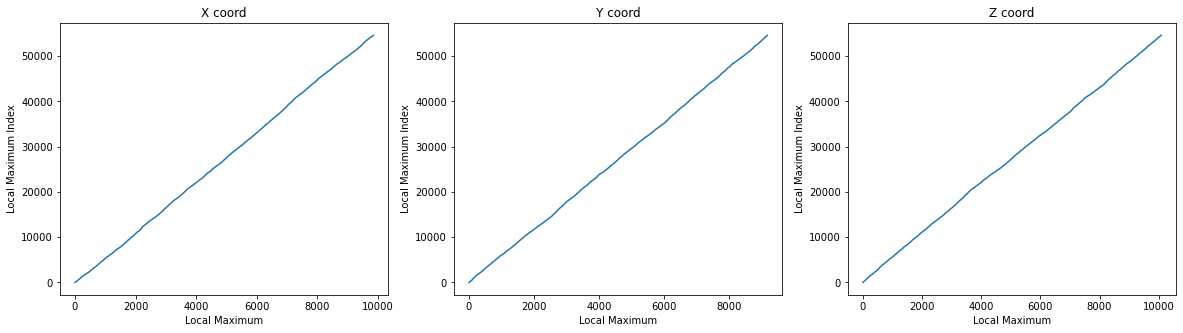

The mean maxima jump (in seconds) is:  5.949164369117879
The mean maxima jump (in seconds) is:  4.346025092956537
The mean maxima jump (in seconds) is:  6.8539468395835215
Overall mean jump (in seconds): 5.716378767219312


In [167]:
maxima_X = argrelextrema(np.array(data.X), np.greater)
maxima_Y = argrelextrema(np.array(data.Y), np.greater)
maxima_Z = argrelextrema(np.array(data.Z), np.greater)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(maxima_X[0])
plt.title("X coord")
plt.ylabel("Local Maximum Index")
plt.xlabel("Local Maximum")
plt.subplot(1,3,2)
plt.plot(maxima_Y[0])
plt.title("Y coord")
plt.ylabel("Local Maximum Index")
plt.xlabel("Local Maximum")
plt.subplot(1,3,3)
plt.plot(maxima_Z[0])
plt.title("Z coord")
plt.ylabel("Local Maximum Index")
plt.xlabel("Local Maximum")
plt.show()

X_x = maxima_X[0]
X_y = np.arange(0,len(X_x))
Y_x = maxima_Y[0]
Y_y = np.arange(0,len(Y_x))
Z_x = maxima_Z[0]
Z_y = np.arange(0,len(Z_x))

m_X = (len(X_x) * np.sum(X_x*X_y) - np.sum(X_x) * np.sum(X_y))/(len(x)*np.sum(X_x*X_x) - np.sum(X_x) ** 2)
m_Y = (len(Y_x) * np.sum(Y_x*Y_y) - np.sum(Y_x) * np.sum(Y_y))/(len(x)*np.sum(Y_x*Y_x) - np.sum(Y_x) ** 2)
m_Z = (len(Z_x) * np.sum(Z_x*Z_y) - np.sum(Z_x) * np.sum(Z_y))/(len(x)*np.sum(Z_x*Z_x) - np.sum(Z_x) ** 2)
    
#print("The best fit slope of X is: ", m_X)
print("The mean maxima jump (in seconds) is: ", m_X/0.03)
#print("The best fit slope of Y is: ", m_Y)
print("The mean maxima jump (in seconds) is: ", m_Y/0.03)
#print("The best fit slope of Z is: ", m_Z)
print("The mean maxima jump (in seconds) is: ", m_Z/0.03)
print("Overall mean jump (in seconds):", ((m_X/0.03)+(m_Y/0.03)+(m_Z/0.03))/3)

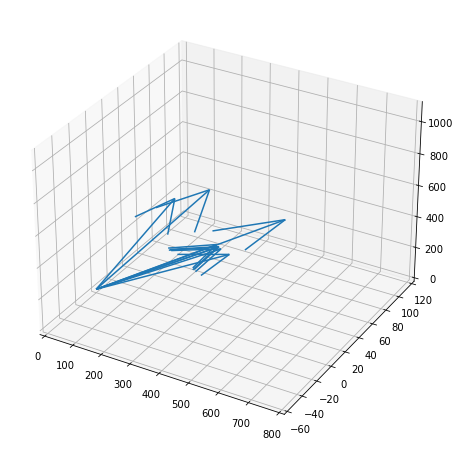

In [91]:
soa = np.array([[0,0,0,data.X[0],data.Y[0],data.Z[0]],
                [0,0,0,data.X[100],data.Y[100],data.Z[100]],
                [0,0,0,data.X[200],data.Y[200],data.Z[200]],
                [0,0,0,data.X[300],data.Y[300],data.Z[300]],
                [0,0,0,data.X[400],data.Y[400],data.Z[400]],
                [0,0,0,data.X[500],data.Y[500],data.Z[500]],
                [0,0,0,data.X[600],data.Y[600],data.Z[600]],
                [0,0,0,data.X[700],data.Y[700],data.Z[700]],
                [0,0,0,data.X[800],data.Y[800],data.Z[800]]])

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-0.2, 800])
ax.set_ylim([-60, 120])
ax.set_zlim([-0.2, 1100])
plt.show()